In [ ]:
from google.colab import drive
import os
drive.mount('/gdrive')
os.chdir("/gdrive/My Drive/MLcontent/")

Mounted at /gdrive


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rn
from tensorflow.compat.v1.keras import backend as K
print(tf.__version__)

2.3.0


In [ ]:
n = 5
np.random.seed(100 * n)
rn.seed(10000 * n)
#Depending on the actual running environment, you may specify if using GPU, or only CPU.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#Tensorflow session configuration.
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

tf.compat.v1.set_random_seed(1000 * n)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

K.set_session(sess)

In [ ]:
series = pd.read_csv('Wastewater_Data.csv', header=0, parse_dates=[0], index_col=0,squeeze=True)
series = series.replace('^\s*$', np.nan, regex=True)
series = series.fillna(method='ffill')
series = series.apply(pd.to_numeric)


In [ ]:
#select feature
f = 'Total Solids'

TVsize = int(len(series) * 0.6)
VTsize = int(len(series) * 0.8)
shiftDF = series[f]
#select target
targetname = 'Total Solids'
targetDF = series[targetname]
train_data = shiftDF[0:TVsize]
train_target = targetDF[0:TVsize]

val_data = shiftDF[TVsize:VTsize]
val_target = targetDF[TVsize:VTsize]

test_data = shiftDF[VTsize:]
test_target = targetDF[VTsize:]



In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
window_size = 3
shuffle_buffer_size = 1000
train_set = windowed_dataset(train_data, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 13ms/step - loss: 958.1210 - mae: 958.6210
Epoch 2/100
31/31 [==============================] - 1s 17ms/step - loss: 956.3491 - mae: 956.8491
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 954.2474 - mae: 954.7474
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 951.9698 - mae: 952.4698
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 948.9906 - mae: 949.4907
Epoch 6/100
31/31 [==============================] - 0s 16ms/step - loss: 944.1930 - mae: 944.6929
Epoch 7/100
31/31 [==============================] - 1s 17ms/step - loss: 941.7914 - mae: 942.2916
Epoch 8/100
31/31 [==============================] - 0s 15ms/step - loss: 938.4581 - mae: 938.9579
Epoch 9/100
31/31 [==============================] - 0s 13ms/step - loss: 929.4637 - mae: 929.9640
Epoch 10/100
31/31 [==============================] - 0s 14ms/step - loss: 923.1979 - mae: 923.6979
Epoch 11/

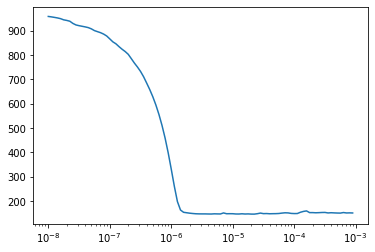

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 30])


In [ ]:
train_set

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
batch_size = 7
dataset = windowed_dataset(train_data, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=3e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=50)

Epoch 1/50
563/563 [==============================] - 3s 6ms/step - loss: 385.7039 - mae: 386.2035
Epoch 2/50
563/563 [==============================] - 4s 7ms/step - loss: 157.6829 - mae: 158.1819
Epoch 3/50
563/563 [==============================] - 4s 7ms/step - loss: 150.5436 - mae: 151.0426
Epoch 4/50
563/563 [==============================] - 3s 5ms/step - loss: 149.6576 - mae: 150.1567
Epoch 5/50
563/563 [==============================] - 3s 5ms/step - loss: 149.3451 - mae: 149.8443
Epoch 6/50
563/563 [==============================] - 3s 5ms/step - loss: 149.0716 - mae: 149.5705
Epoch 7/50
563/563 [==============================] - 3s 5ms/step - loss: 149.1812 - mae: 149.6805
Epoch 8/50
563/563 [==============================] - 3s 5ms/step - loss: 148.9802 - mae: 149.4794
Epoch 9/50
563/563 [==============================] - 3s 5ms/step - loss: 148.9817 - mae: 149.4809
Epoch 10/50
563/563 [==============================] - 3s 5ms/step - loss: 148.8690 - mae: 149.3681
Epoch 11/